In [1]:
import requests
import asyncio
import aiohttp
import time
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import pandas as pd
from multiprocess import Pool


In [2]:
test_requests = [
    {
        "model_name": "distilbert-base-uncased",
        "text": "This is a great product! I love it.",
        "task": "text-classification",
        "max_length": 512
    },
    {
        "model_name": "bert-base-uncased",
        "text": "The quick brown fox jumps over the lazy dog.",
        "task": "feature-extraction",
        "max_length": 128
    },
    {
        "model_name": "distilbert-base-uncased",
        "text": "This movie is terrible. I hate it.",
        "task": "text-classification",
        "max_length": 512
    },
    {
        "model_name": "nilq/mistral-1L-tiny",
        "text": "Once upon a time",
        "task": "text-generation",
        "max_length": 50,
        "parameters": {"temperature": 0.7, "do_sample": True}
    },
    {
        "model_name": "bert-base-uncased",
        "text": "Natural language processing is fascinating.",
        "task": "feature-extraction",
        "max_length": 128
    }
]

### Utility functions

In [3]:


def check_server_health(SERVER_URL):
    """Check if the server is running"""
    try:
        response = requests.get(f"{SERVER_URL}/health", timeout=5)
        if response.status_code == 200:
            print("✅ Server is healthy and running")
            return True
        else:
            print(f"❌ Server health check failed: {response.status_code}")
            return False
    except Exception as e:
        print(f"❌ Cannot connect to server: {e}")
        return False
    
def single_request(request_data, request_id, SERVER_URL):
    """Make a single inference request"""
    try:
        start_time = time.time()
        response = requests.post(
            f"{SERVER_URL}/predict",
            json=request_data,
            timeout=60
        )
        end_time = time.time()
        
        if response.status_code == 200:
            result = response.json()
            return {
                "request_id": request_id,
                "success": True,
                "response": result,
                "request_time": end_time - start_time,
                "processing_time": result.get("processing_time", 0)
            }
        else:
            return {
                "request_id": request_id,
                "success": False,
                "error": response.text,
                "request_time": end_time - start_time
            }
    except Exception as e:
        return {
            "request_id": request_id,
            "success": False,
            "error": str(e),
            "request_time": time.time() - start_time
        }

async def async_request(session, request_data, request_id, SERVER_URL):
    """Make an async inference request"""
    try:
        start_time = time.time()
        async with session.post(
            f"{SERVER_URL}/predict",
            json=request_data,
            timeout=aiohttp.ClientTimeout(total=60)
        ) as response:
            end_time = time.time()
            
            if response.status == 200:
                result = await response.json()
                return {
                    "request_id": request_id,
                    "success": True,
                    "response": result,
                    "request_time": end_time - start_time,
                    "processing_time": result.get("processing_time", 0)
                }
            else:
                error_text = await response.text()
                return {
                    "request_id": request_id,
                    "success": False,
                    "error": error_text,
                    "request_time": end_time - start_time
                }
    except Exception as e:
        return {
            "request_id": request_id,
            "success": False,
            "error": str(e),
            "request_time": time.time() - start_time
        }

def test_sequential_requests(test_requests, SERVER_URL):
    """Test sequential requests"""
    print("\n🔄 Testing Sequential Requests...")
    results = []
    total_start = time.time()
    
    for i, request_data in enumerate(test_requests):
        print(f"Request {i+1}: {request_data['model_name']} - {request_data['task']}")
        result = single_request(request_data, i+1, SERVER_URL)
        results.append(result)
        
        if result["success"]:
            print(f"  ✅ Success (Request: {result['request_time']:.2f}s, Processing: {result['processing_time']:.2f}s)")
        else:
            print(f"  ❌ Failed: {result['error']}")
    
    total_time = time.time() - total_start
    print(f"\n📊 Sequential Results:")
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Average per request: {total_time/len(test_requests):.2f}s")
    
    return results

def test_parallel_requests_threading(test_requests, SERVER_URL):
    """Test parallel requests using threading"""
    # This is basically one thread per request
    print("\n🚀 Testing Parallel Requests (Threading)...")
    
    total_start = time.time()
    results = []
    
    with ThreadPoolExecutor(max_workers=5) as executor:
        # Submit all requests
        futures = {
            executor.submit(single_request, request_data, i+1, SERVER_URL ): (i+1, request_data)
            for i, request_data in enumerate(test_requests)
        }
        
        # Collect results as they complete
        for future in as_completed(futures):
            request_id, request_data = futures[future]
            result = future.result()
            results.append(result)
            
            if result["success"]:
                print(f"Request {request_id} completed ✅ (Request: {result['request_time']:.2f}s, Processing: {result['processing_time']:.2f}s)")
            else:
                print(f"Request {request_id} failed ❌: {result['error']}")
    
    total_time = time.time() - total_start
    successful_requests = [r for r in results if r["success"]]
    
    print(f"\n📊 Parallel Threading Results:")
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Successful requests: {len(successful_requests)}/{len(test_requests)}")
    if successful_requests:
        avg_processing = sum(r["processing_time"] for r in successful_requests) / len(successful_requests)
        print(f"  Average processing time: {avg_processing:.2f}s")
    
    return results

async def test_parallel_requests_async(test_requests, SERVER_URL):
    """Test parallel requests using async/await"""
    print("\n⚡ Testing Parallel Requests (Async)...")
    
    total_start = time.time()
    
    async with aiohttp.ClientSession() as session:
        # Create all request tasks
        tasks = [
            async_request(session, request_data, i+1, SERVER_URL)
            for i, request_data in enumerate(test_requests)
        ]
        
        # Execute all requests concurrently
        results = await asyncio.gather(*tasks)
    
    total_time = time.time() - total_start
    successful_requests = [r for r in results if r["success"]]
    
    print(f"\n📊 Parallel Async Results:")
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Successful requests: {len(successful_requests)}/{len(test_requests)}")
    
    for result in results:
        if result["success"]:
            print(f"Request {result['request_id']} ✅ (Request: {result['request_time']:.2f}s, Processing: {result['processing_time']:.2f}s)")
        else:
            print(f"Request {result['request_id']} ❌: {result['error']}")
    
    if successful_requests:
        avg_processing = sum(r["processing_time"] for r in successful_requests) / len(successful_requests)
        print(f"  Average processing time: {avg_processing:.2f}s")
    
    return results



def test_parallel_requests_multiprocessing(test_requests, SERVER_URL):
    """Test parallel requests using multiprocess (Jupyter-compatible)"""
    print("\n🔄 Testing Parallel Requests (Multiprocess)...")

    def single_request(request_data, request_id, SERVER_URL):
        """Make a single inference request"""
        try:
            start_time = time.time()
            response = requests.post(
                f"{SERVER_URL}/predict",
                json=request_data,
                timeout=60
            )
            end_time = time.time()
            
            if response.status_code == 200:
                result = response.json()
                return {
                    "request_id": request_id,
                    "success": True,
                    "response": result,
                    "request_time": end_time - start_time,
                    "processing_time": result.get("processing_time", 0)
                }
            else:
                return {
                    "request_id": request_id,
                    "success": False,
                    "error": response.text,
                    "request_time": end_time - start_time
                }
        except Exception as e:
            return {
                "request_id": request_id,
                "success": False,
                "error": str(e),
                "request_time": time.time() - start_time
            }


    total_start = time.time()

    with Pool(processes=5) as pool:
        results = pool.starmap(single_request, [
            (request_data, i + 1, SERVER_URL)
            for i, request_data in enumerate(test_requests)
        ])

    total_time = time.time() - total_start
    successful_requests = [r for r in results if r["success"]]

    print(f"\n📊 Parallel Multiprocessing Results:")
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Successful requests: {len(successful_requests)}/{len(test_requests)}")

    for result in results:
        if result["success"]:
            print(f"Request {result['request_id']} ✅ (Request: {result['request_time']:.2f}s, Processing: {result['processing_time']:.2f}s)")
        else:
            print(f"Request {result['request_id']} ❌: {result['error']}")

    if successful_requests:
        avg_processing = sum(r["processing_time"] for r in successful_requests if r["processing_time"]) / len(successful_requests)
        print(f"  Average processing time: {avg_processing:.2f}s")

    return results

def test_batch_request(test_requests, SERVER_URL):
    """Test batch inference endpoint"""
    print("\n📦 Testing Batch Request...")
    
    try:
        start_time = time.time()
        response = requests.post(
            f"{SERVER_URL}/batch_predict",
            json=test_requests,
            timeout=120
        )
        end_time = time.time()
        
        if response.status_code == 200:
            result = response.json()
            print(f"✅ Batch request successful")
            print(f"  Total time: {end_time - start_time:.2f}s")
            print(f"  Server processing time: {result['total_processing_time']:.2f}s")
            print(f"  Batch size: {result['batch_size']}")
            
            successful = sum(1 for r in result['results'] if not isinstance(r, dict) or 'error' not in r)
            print(f"  Successful requests: {successful}/{result['batch_size']}")
            
            return result
        else:
            print(f"❌ Batch request failed: {response.text}")
            return None
            
    except Exception as e:
        print(f"❌ Batch request error: {e}")
        return None

def get_server_info(SERVER_URL):
    """Get server information"""
    try:
        response = requests.get(f"{SERVER_URL}/models")
        if response.status_code == 200:
            info = response.json()
            print(f"\n🖥️  Server Information:")
            print(f"  Device: {info['device']}")
            print(f"  Loaded models: {info['cache_size']}")
            if info['loaded_models']:
                for model in info['loaded_models']:
                    print(f"    - {model}")
        else:
            print("❌ Could not get server info")
    except Exception as e:
        print(f"❌ Error getting server info: {e}")

def plot_performance_comparison(sequential_results, parallel_results, async_results, batch_results, multiprocessing_results, SERVER):
    """Plot performance comparison"""
    try:
        # Calculate metrics
        sequential_time = sum(r.get("request_time", 0) for r in sequential_results if r["success"])
        parallel_time = sum(r.get("request_time", 0) for r in parallel_results if r["success"])
        async_time = sum(r.get("request_time", 0) for r in async_results if r["success"])
        batch_time = batch_results['total_processing_time'] if batch_results else 0
        multiprocessing_time = sum(r.get("request_time", 0) for r in multiprocessing_results if r["success"])
        
        methods = ['Sequential', 'Parallel (Threading)', 'Parallel (Async)', 'Batch', 'Parallel (Multiprocessing)']
        times = [sequential_time, parallel_time, async_time, batch_time, multiprocessing_time]     
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(methods, times, color=['red', 'blue', 'green', 'orange', 'purple'])
        plt.title('Request Processing Time Comparison')
        plt.ylabel('Total Time (seconds)')
        plt.xlabel('Method')
        
        # Add value labels on bars
        for bar, time in zip(bars, times):

            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{time:.2f}s', ha='center', va='bottom')
            
        
        plt.tight_layout()
        plt.show()
        
        # Show speedup
        if sequential_time > 0:
            parallel_speedup = sequential_time / parallel_time if parallel_time > 0 else 0
            async_speedup = sequential_time / async_time if async_time > 0 else 0
            batch_speedup = sequential_time / batch_time if batch_time > 0 else 0
            multi_speedup = sequential_time / multiprocessing_time if multiprocessing_time > 0 else 0
            
            print(f"\n🚀 Performance Speedup:")
            print(f"  Threading speedup: {parallel_speedup:.2f}x")
            print(f"  Async speedup: {async_speedup:.2f}x")
            print(f"  Batch speedup: {batch_speedup:.2f}x")
            print(f"  Multiprocessing speedup: {sequential_time / multiprocessing_time:.2f}x")
        else:
            print("\n🚨 No sequential requests were successful, cannot calculate speedup.")
            
    except Exception as e:
        print(f"❌ Error creating plot: {e}")

async def doTests(SERVER_URL):
    """Run all tests"""
    if not check_server_health(SERVER_URL):
        return
    
    get_server_info(SERVER_URL)
    
    sequential_results = test_sequential_requests(test_requests, SERVER_URL)
    parallel_results = test_parallel_requests_threading(test_requests, SERVER_URL)
    async_results = await test_parallel_requests_async(test_requests, SERVER_URL)
    batch_results = test_batch_request(test_requests, SERVER_URL)
    multiprocessing_results = test_parallel_requests_multiprocessing(test_requests, SERVER_URL)
    
    plot_performance_comparison(sequential_results, parallel_results, async_results, batch_results, multiprocessing_results, SERVER_URL)


🔍 Starting performance test for server http://localhost:80 with 5 requests...

🖥️  Server Information:
  Device: cpu
  Loaded models: 3
    - distilbert-base-uncased_text-classification
    - bert-base-uncased_feature-extraction
    - nilq/mistral-1L-tiny_text-generation

🔄 Testing Sequential Requests...
Request 1: distilbert-base-uncased - text-classification
  ✅ Success (Request: 0.27s, Processing: 0.26s)
Request 2: bert-base-uncased - feature-extraction
  ✅ Success (Request: 0.46s, Processing: 0.45s)
Request 3: distilbert-base-uncased - text-classification
  ✅ Success (Request: 0.24s, Processing: 0.24s)
Request 4: nilq/mistral-1L-tiny - text-generation
  ✅ Success (Request: 1.35s, Processing: 1.35s)
Request 5: bert-base-uncased - feature-extraction
  ✅ Success (Request: 0.22s, Processing: 0.21s)

📊 Sequential Results:
  Total time: 2.54s
  Average per request: 0.51s
✅ Server is healthy and running

🚀 Testing Parallel Requests (Threading)...
Request 1 completed ✅ (Request: 0.71s, Pro

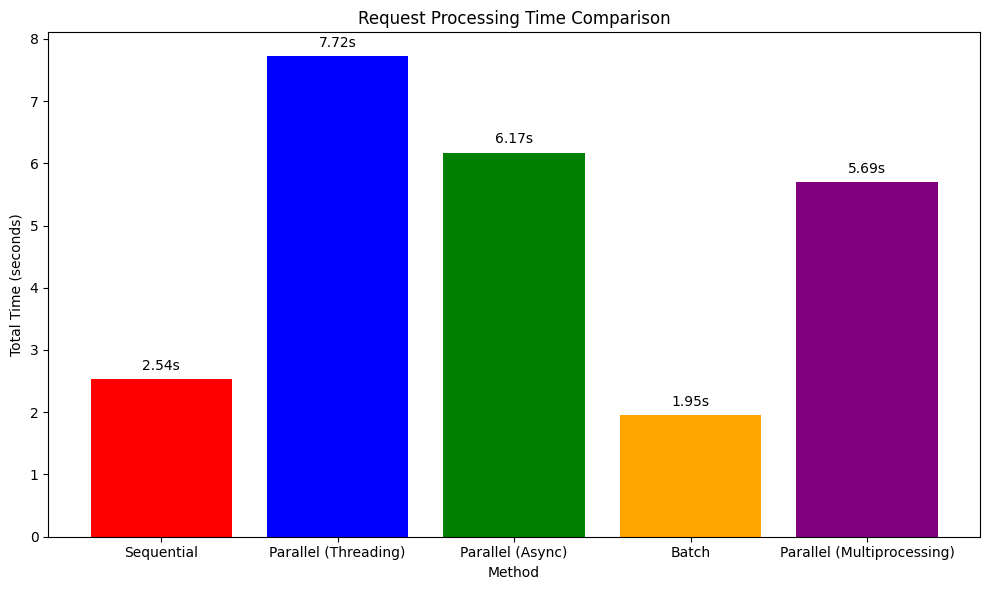


🚀 Performance Speedup:
  Threading speedup: 0.33x
  Async speedup: 0.41x
  Batch speedup: 1.30x
  Multiprocessing speedup: 0.45x

✅ All tests completed successfully!


In [ ]:
SERVER_URL = "http://localhost:80"  
print(f"🔍 Starting performance test for server {SERVER_URL} with {len(test_requests)} requests...")
await doTests(SERVER_URL)

🔍 Starting performance test for server http://localhost:8000 with 5 requests...
✅ Server is healthy and running

🖥️  Server Information:
  Device: cpu
  Loaded models: 0

🔄 Testing Sequential Requests...
Request 1: distilbert-base-uncased - text-classification
  ✅ Success (Request: 6.24s, Processing: 6.27s)
Request 2: bert-base-uncased - feature-extraction
  ✅ Success (Request: 8.05s, Processing: 8.04s)
Request 3: distilbert-base-uncased - text-classification
  ✅ Success (Request: 0.21s, Processing: 0.20s)
Request 4: nilq/mistral-1L-tiny - text-generation
  ✅ Success (Request: 4.66s, Processing: 4.66s)
Request 5: bert-base-uncased - feature-extraction
  ✅ Success (Request: 0.13s, Processing: 0.13s)

📊 Sequential Results:
  Total time: 19.29s
  Average per request: 3.86s

🚀 Testing Parallel Requests (Threading)...
Request 2 completed ✅ (Request: 0.31s, Processing: 0.31s)
Request 1 completed ✅ (Request: 0.45s, Processing: 0.14s)
Request 3 completed ✅ (Request: 0.57s, Processing: 0.11s)
R

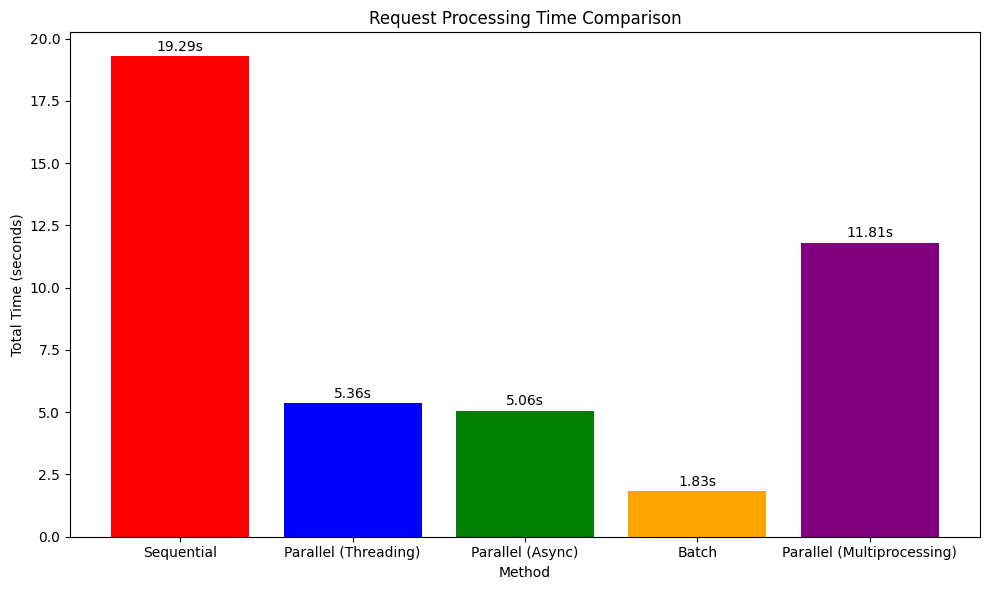


🚀 Performance Speedup:
  Threading speedup: 3.60x
  Async speedup: 3.81x
  Batch speedup: 10.52x
  Multiprocessing speedup: 1.63x


In [4]:
SERVER_URL = "http://localhost:8000"  
print(f"🔍 Starting performance test for server {SERVER_URL} with {len(test_requests)} requests...")

await doTests(SERVER_URL)

## Now scaling with three

✅ Server is healthy and running

🖥️  Server Information:
  Device: cpu
  Loaded models: 3
    - distilbert-base-uncased_text-classification
    - nilq/mistral-1L-tiny_text-generation
    - bert-base-uncased_feature-extraction


{'request_id': 0,
 'success': True,
 'response': {'model_name': 'nilq/mistral-1L-tiny',
  'result': 'My favorite flavoured ice cream is strawberry." \n\nMummy said, "I want some strawberry ice cream!"\n\n"Me too!" said Lucy. "Let\'s go pay the ice cream!"\n\nSo they went',
  'processing_time': 1.3114473819732666,
  'task': 'text-generation'},
 'request_time': 1.3154809474945068,
 'processing_time': 1.3114473819732666}